# Craiglist Car Price Residual Anomoly

In this book, we examine the strange behavior of the residual plots in our Car Price analysis. It turns out that abounding duplicate price values causes the edge behaviour of the plot.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('craigslistVehicles.csv')

**Data Cleaning** 

In [7]:
df = df[df.price >1000] #nuke the cars with price <1000 (arbitrary)
df = df[df.price < 200000] # 200,000 is a reasonable cap for the purpose of nuking outliers

df.drop(['url', 'city', 'city_url','VIN','image_url', 'lat', 'long',
        'manufacturer','make','size','desc'],axis=1,inplace=True)

df['odometer'].fillna((df['odometer'].mean()), inplace=True)

df.dropna(inplace=True)

In [8]:
text_cols = df.select_dtypes(include=['object']).columns
dummy_cols = pd.DataFrame()
for col in text_cols:
    col_dummies = pd.get_dummies(df[col])
    df = pd.concat([df, col_dummies], axis=1)
    del df[col]

**Linear Regression**

In [11]:
from sklearn.model_selection import train_test_split

X=df.drop(['price'],axis=1)
y=df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Text(0.5, 1.0, 'Residual vs Predicted')

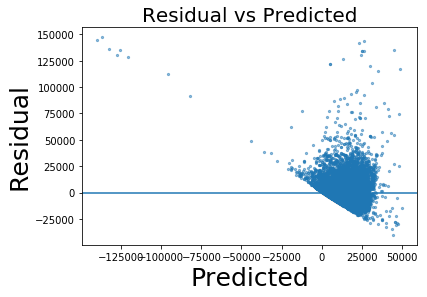

In [12]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)

predicted = lm.predict(X_test)
residual = Y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [13]:
df['price'].value_counts().sort_index(ascending=True).head(15)

1025      1
1050     13
1075      7
1080      1
1090      1
1095      1
1098      1
1099      1
1100    184
1111      2
1150     23
1175      3
1188      1
1190      2
1195     24
Name: price, dtype: int64

**The Culprit**

Notice that there are values that appear many times as a result of the price field being rounded to the nearest dollar. Many duplicate Y's with varying X's so to speak has the effect of skewing our residual plots. 

Let's drop the duplicates and run our model on the reduced dataset.

In [14]:
df2 = df.drop_duplicates(subset='price')

In [15]:
df2.shape

(5561, 59)

In [26]:
X=df2.drop(['price'],axis=1)
y=df2['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Text(0.5, 1.0, 'Residual vs Predicted')

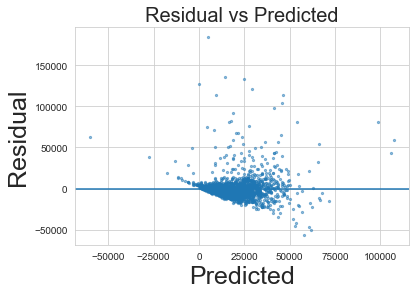

In [27]:
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)

predicted = lm.predict(X_test)
residual = Y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

**There is still some odd behavior but could this be due to outliers now?**

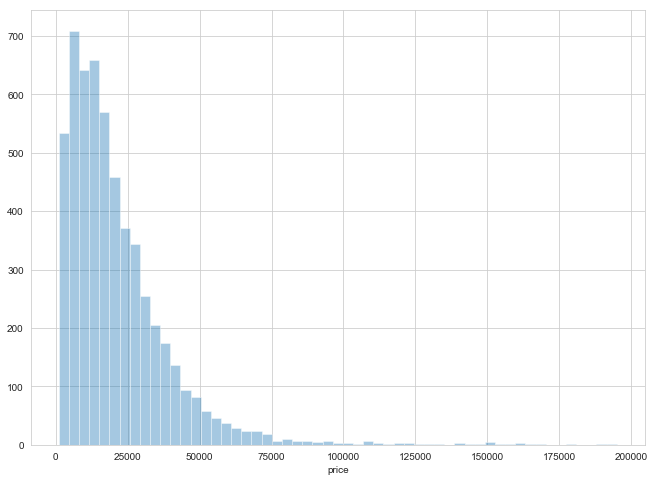

In [22]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize = (11, 8))
sns.distplot(df2.price, kde=False, bins=55)

**Let's take the log of the price field to lessen the impact of outliers.**

Text(0.5, 1.0, 'Residual vs Predicted')

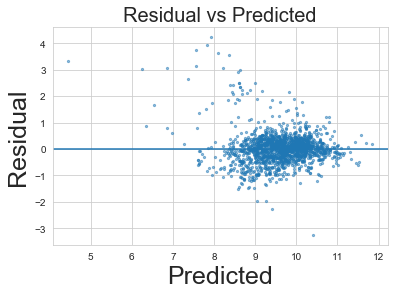

In [23]:
X=df2.drop('price',axis=1)
y=np.log(df2['price'])

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = linear_model.LinearRegression()    
lm.fit(X_train, Y_train)

predicted = lm.predict(X_test)
residual = Y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

**That does the trick.**